In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.manifold import TSNE

# Load dataset
def load_data(file_path):
    """Loads text data from a file."""
    with open(file_path, 'r') as file:
        text = file.read()
    return text

# Clean text
def clean_text(text):
    """Cleans the text by removing URLs, special characters, and converting to lowercase."""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub('[^a-zA-Z0-9 \.]', '', text)  # Remove special characters
    text = text.lower()  # Convert text to lowercase
    return text

# Load and clean data
file_path = '/content/sherlock.txt'  # Replace with your dataset path
text = load_data(file_path)
cleaned_text = clean_text(text)
words = cleaned_text.split()

# Create vocabulary
unique_words = sorted(set(words))
stoi = {s: i + 1 for i, s in enumerate(unique_words)}  # String to index
itos = {i: s for s, i in stoi.items()}  # Index to string

# Print vocabulary size
print(f"Vocabulary Size: {len(stoi)}")

# Additional steps, like creating training data or embedding visualizations, could go here.


Vocabulary Size: 16813


In [3]:
import torch
torch.cuda.is_available()  # Returns True if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
block_size = 10  # Number of words to predict the next one
X, Y = [], []

for i in range(len(words) - block_size):
    context = words[i:i + block_size]  # Get the context of words
    next_word = words[i + block_size]  # Get the next word
    X.append([stoi[w] for w in context])  # Append the context as indices
    Y.append(stoi[next_word])  # Append the next word index

# Convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

# Print the input-output pairs
for i in range(len(X)):
    context_words = [itos[idx.item()] for idx in X[i]]  # Convert indices back to words
    next_word = itos[Y[i].item()]  # Convert index to word
    print(f" {' '.join(context_words)} --->  {next_word}")


Streaming output truncated to the last 5000 lines.
 into the arms of mr. rucastle who was waitingoutside.so said --->  he
 the arms of mr. rucastle who was waitingoutside.so said he --->  smiling
 arms of mr. rucastle who was waitingoutside.so said he smiling --->  it
 of mr. rucastle who was waitingoutside.so said he smiling it --->  was
 mr. rucastle who was waitingoutside.so said he smiling it was --->  you
 rucastle who was waitingoutside.so said he smiling it was you --->  then.
 who was waitingoutside.so said he smiling it was you then. --->  i
 was waitingoutside.so said he smiling it was you then. i --->  thought
 waitingoutside.so said he smiling it was you then. i thought --->  that
 said he smiling it was you then. i thought that --->  it
 he smiling it was you then. i thought that it --->  must
 smiling it was you then. i thought that it must --->  bewhen
 it was you then. i thought that it must bewhen --->  i
 was you then. i thought that it must bewhen i --->  saw
 you th

In [5]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size):
        super(NextWordMLP, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the input
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Initialize model
model_relu_64_10 = NextWordMLP(len(stoi) + 1, emb_dim=64, hidden_size=1024).to(device)


In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Select a subset of words (for example, 100 words)
selected_words = [
    "detect", "discover", "hide", "expose", "appear", "vanish",
    "observe", "notice", "truth", "lie", "crime", "justice",
    "clue", "evidence", "suspect", "accuse", "mystery", "solution",
    "search", "find", "silent", "speak", "solve", "unravel",
    "conceal", "reveal", "doubt", "certainty", "question", "answer",
    "sherlock", "watson", "holmes", "baker", "london", "night",
    "door", "case", "strange", "letter", "fear", "mind",
    "fact", "story", "secret", "danger", "friend", "enemy",
    "plan", "proof"
]
selected_indices = [stoi[word] for word in selected_words if word in stoi]

# Step 2: Get embeddings before training
with torch.no_grad():
    model_relu_64_10.eval()
    embeddings_before = model_relu_64_10.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()

In [7]:
torch.cuda.empty_cache()

In [8]:
import torch
import torch.nn as nn
import time

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
emb_dim = 64  # Embedding dimension for words
hidden_size = 1024  # Size of hidden layer
block_size = 10 # Context length (number of words to predict the next one)
vocab_size = len(stoi)  # Size of the vocabulary
batch_size = 1500
print_every = 50
elapsed_time = []

# Initialize model, loss function, and optimizer
model_relu_64_10 = NextWordMLP(vocab_size + 1, emb_dim=emb_dim, hidden_size=hidden_size).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model_relu_64_10.parameters(), lr=0.01)

# Move data to the GPU
X = X.to(device)
Y = Y.to(device)

# Training loop
for epoch in range(800):  # Loop for specified epochs

    model_relu_64_10.train()  # Set model to training mode

    # Mini-batch processing
    for i in range(0, X.shape[0], batch_size):
        x_batch = X[i:i + batch_size].to(device)  # Get the batch of input sequences
        y_batch = Y[i:i + batch_size].to(device)  # Get the batch of next word labels

        # Forward pass: predict the next word
        y_pred = model_relu_64_10(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Clear previous gradients
        opt.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer
        opt.step()




    # Print loss at intervals
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete")


Epoch 0, Loss: 10.84878921508789
Epoch 50, Loss: 0.00024148433294612914
Epoch 100, Loss: 0.9197853803634644
Epoch 150, Loss: 0.00018077476124744862
Epoch 200, Loss: 7.620968972332776e-05
Epoch 250, Loss: 0.0003916768473573029
Epoch 300, Loss: 0.00012084636546205729
Epoch 350, Loss: 0.006177256349474192
Epoch 400, Loss: 0.00016784467152319849
Epoch 450, Loss: 0.0004969055880792439
Epoch 500, Loss: 7.483510971069336
Epoch 550, Loss: 0.0002968450717162341
Epoch 600, Loss: 0.5289541482925415
Epoch 650, Loss: 0.00016870377294253558
Epoch 700, Loss: 5.31601435795892e-05
Epoch 750, Loss: 0.00015401802374981344
Training complete


In [9]:
torch.save(model_relu_64_10.state_dict(), 'model_relu_64_10.pth')


In [10]:
with torch.no_grad():
    embeddings_after = model_relu_64_10.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()

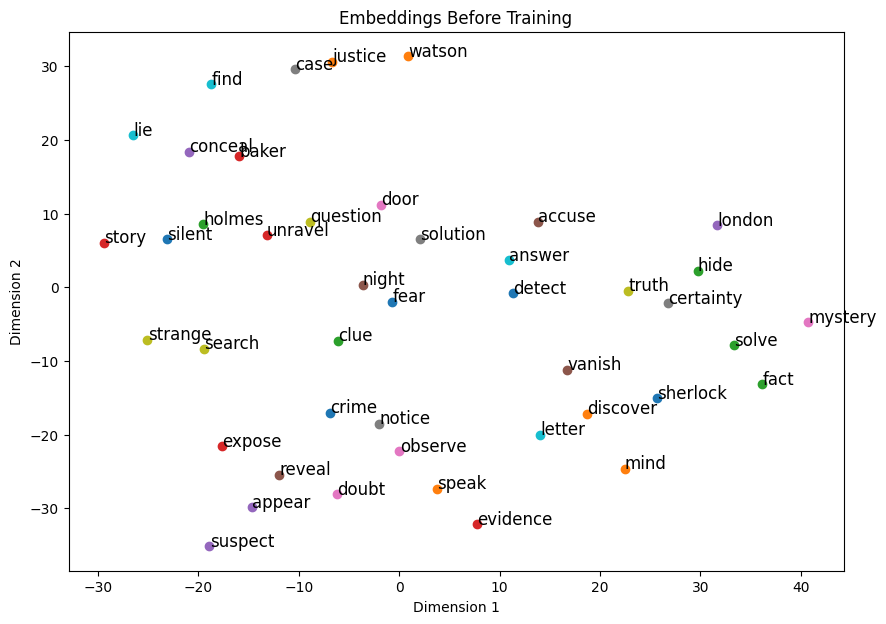

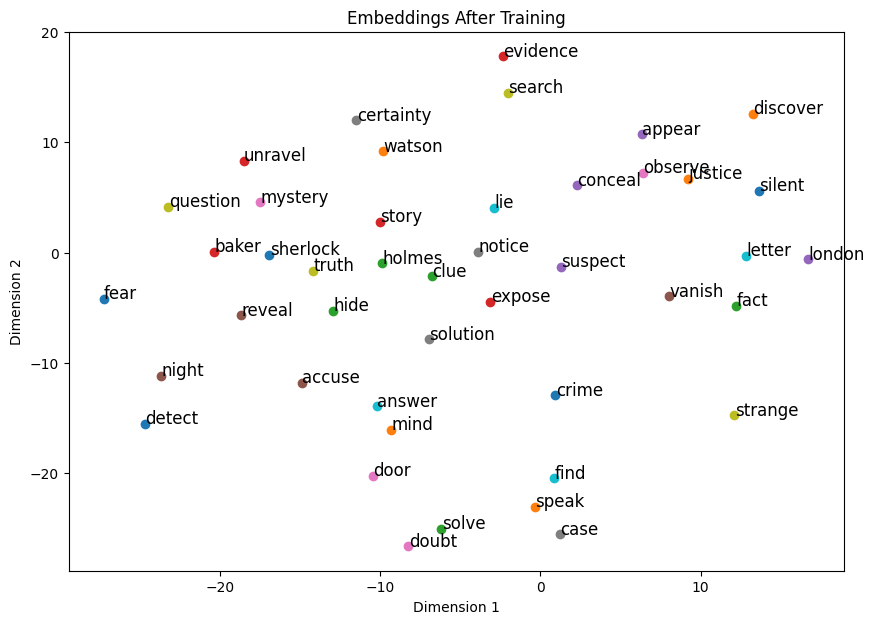

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `embeddings_before` and `embeddings_after` are initialized
sample_size = len(embeddings_before)
perplexity = min(5, sample_size - 1)  # Set a smaller perplexity if needed

# Initialize t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
embeddings_before_2d = tsne.fit_transform(embeddings_before)
embeddings_after_2d = tsne.fit_transform(embeddings_after)

# Adjust selected_words to match the length of embeddings
selected_words = selected_words[:len(embeddings_before_2d)]

# Plot function
def plot_embeddings(embeddings, words, title):
    plt.figure(figsize=(10, 7))
    for i, word in enumerate(words):
        x, y = embeddings[i]
        plt.scatter(x, y)
        plt.text(x + 0.02, y + 0.02, word, fontsize=12)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot before and after training
plot_embeddings(embeddings_before_2d, selected_words, "Embeddings Before Training")
plot_embeddings(embeddings_after_2d, selected_words, "Embeddings After Training")


In [13]:
def predict_next_word(model, context_words, top_k=1):
    model.eval()  # Set the model to evaluation mode

    # Preprocess the input (convert words to indices)
    context_indices = [stoi[word] for word in context_words]

    # Convert to tensor and move to GPU
    context_tensor = torch.tensor(context_indices, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(context_tensor)
        probabilities = F.softmax(output, dim=-1)

        # Get the top_k predictions
        top_k_probs, top_k_indices = torch.topk(probabilities, top_k, dim=-1)

        predicted_words = [list(stoi.keys())[index.item()] for index in top_k_indices.squeeze()]

    return predicted_words

# Example usage
context = ["the", "cat", "is", "sitting", "on", "the","mat","and","looking","at"]
predicted_word = predict_next_word(model_relu_64_10, context, top_k=3)
print("Predicted next words:", predicted_word)

Predicted next words: ['theaffairs', 'myadventures', 'someattention']
